# 2024 Winter Introduction to Deep Learning
### Based on Prof. Oh's Youtube Lecture
https://youtube.com/playlist?list=PLvbUC2Zh5oJvByu9KL82bswYT2IKf0K1M

> Assignment #9


*   Youtube Lecture #36-40
*   Written by Seungeun Lee

## 1. Vanilla GAN
*     Reference. https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/generative_adversarial_network/main.py, https://github.com/Yangyangii/pytorch-practice/blob/master/GAN.ipynb, https://arxiv.org/pdf/1406.2661

In [2]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
import numpy as np
import datetime
import os
import sys
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [3]:
MODEL_NAME = 'GAN'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
def get_sample_image(G, n_noise):
    """
        save sample 100 images
    """
    z = torch.randn(100, n_noise).to(DEVICE)  # 100개의 랜덤 노이즈 벡터 생성
    y_hat = G(z).view(100, 28, 28)  # 생성자(G)로부터 100개의 28x28 이미지 생성
    result = y_hat.cpu().data.numpy()  # 결과를 NumPy 배열로 변환
    img = np.zeros([280, 280])  # 10x10 그리드에 넣을 280x280 빈 이미지 생성
    for j in range(10):
        img[j*28:(j+1)*28] = np.concatenate([x for x in result[j*10:(j+1)*10]], axis=-1)
        # 10개의 이미지를 가로로 연결해 한 줄에 배치
    return img  # 100개의 이미지를 10x10 그리드로 배치한 최종 이미지 반환


In [5]:
class Discriminator(nn.Module):
    """
        Simple Discriminator w/ MLP
    """
    def __init__(self, input_size=784, num_classes=1):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_classes),
            nn.Sigmoid(),
        )

    def forward(self, x):
        y_ = x.view(x.size(0), -1)
        y_ = self.layer(y_)
        return y_

In [6]:
class Generator(nn.Module):
    """
        Simple Generator w/ MLP
    """
    def __init__(self, input_size=100, num_classes=784):
        super(Generator, self).__init__()

        # Generator의 신경망 구조 정의 (MLP 기반)
        self.layer = nn.Sequential(
            nn.Linear(input_size, 128),  # 입력 벡터를 128차원으로 변환
            nn.LeakyReLU(0.2),           # Leaky ReLU 활성화 함수 적용
            nn.Linear(128, 256),         # 128차원을 256차원으로 변환
            nn.BatchNorm1d(256),         # 배치 정규화(Batch Normalization) 적용
            nn.LeakyReLU(0.2),           # Leaky ReLU 활성화 함수 적용
            nn.Linear(256, 512),         # 256차원을 512차원으로 변환
            nn.BatchNorm1d(512),         # 배치 정규화 적용
            nn.LeakyReLU(0.2),           # Leaky ReLU 활성화 함수 적용
            nn.Linear(512, 1024),        # 512차원을 1024차원으로 변환
            nn.BatchNorm1d(1024),        # 배치 정규화 적용
            nn.LeakyReLU(0.2),           # Leaky ReLU 활성화 함수 적용
            nn.Linear(1024, num_classes),# 1024차원을 출력 크기(num_classes)로 변환 (784, 즉 28x28 이미지)
            nn.Tanh()                    # 출력값을 -1과 1 사이로 압축하는 Tanh 함수 적용
        )

    def forward(self, x):
        y_ = self.layer(x)                # 정의한 신경망을 통해 입력 데이터를 변환
        y_ = y_.view(x.size(0), 1, 28, 28) # 출력 벡터를 28x28 크기의 이미지로 변환
        return y_                         # 생성된 이미지를 반환


In [7]:
n_noise = 100

In [8]:
D = Discriminator().to(DEVICE)
G = Generator(n_noise).to(DEVICE)

In [9]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])

In [10]:
mnist = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16426270.22it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 493963.65it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4494413.67it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4811954.73it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [11]:
batch_size = 64
data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True, drop_last=True)

In [12]:
criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [13]:
max_epoch = 50 # need more than 10 epochs for training generator
step = 0
n_critic = 1 # for training more k steps about Discriminator

In [14]:
D_labels = torch.ones(batch_size, 1).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros(batch_size, 1).to(DEVICE) # Discriminator Label to fake

In [15]:
if not os.path.exists('samples'):
    os.makedirs('samples')

In [16]:
for epoch in range(max_epoch):
    for idx, (images, _) in enumerate(data_loader):
        # Training Discriminator
        x = images.to(DEVICE)
        x_outputs = D(x)
        D_x_loss = criterion(x_outputs, D_labels)

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z))
        D_z_loss = criterion(z_outputs, D_fakes)
        D_loss = D_x_loss + D_z_loss

        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        if step % n_critic == 0:
            # Training Generator
            z = torch.randn(batch_size, n_noise).to(DEVICE)
            z_outputs = D(G(z))
            G_loss = criterion(z_outputs, D_labels)

            G.zero_grad()
            G_loss.backward()
            G_opt.step()

        if step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))

        if step % 1000 == 0:
            G.eval()
            img = get_sample_image(G, n_noise)
            imsave('samples/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), img, cmap='gray')
            G.train()
        step += 1

Epoch: 0/50, Step: 0, D Loss: 1.3562469482421875, G Loss: 0.7025243043899536
Epoch: 0/50, Step: 500, D Loss: 1.2617007493972778, G Loss: 0.8946552872657776
Epoch: 1/50, Step: 1000, D Loss: 1.2181189060211182, G Loss: 0.9663476347923279
Epoch: 1/50, Step: 1500, D Loss: 1.171267032623291, G Loss: 0.8152965307235718
Epoch: 2/50, Step: 2000, D Loss: 1.3413845300674438, G Loss: 0.5049197673797607
Epoch: 2/50, Step: 2500, D Loss: 1.2606308460235596, G Loss: 0.8222178220748901
Epoch: 3/50, Step: 3000, D Loss: 1.2403491735458374, G Loss: 1.7655255794525146
Epoch: 3/50, Step: 3500, D Loss: 1.0952279567718506, G Loss: 1.136916160583496
Epoch: 4/50, Step: 4000, D Loss: 1.1830132007598877, G Loss: 1.0485929250717163
Epoch: 4/50, Step: 4500, D Loss: 1.4569222927093506, G Loss: 0.465961754322052
Epoch: 5/50, Step: 5000, D Loss: 1.357730746269226, G Loss: 0.6290168762207031
Epoch: 5/50, Step: 5500, D Loss: 1.235900640487671, G Loss: 0.8057636022567749
Epoch: 6/50, Step: 6000, D Loss: 1.20256614685058

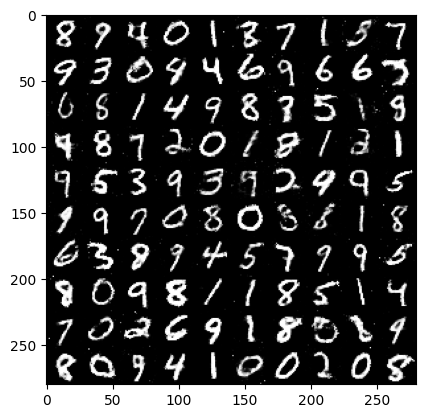

In [17]:
# generation to image
G.eval()
imshow(get_sample_image(G, n_noise), cmap='gray')

In [18]:
# Saving params.
torch.save(D.state_dict(), 'D.pkl')
torch.save(G.state_dict(), 'G.pkl')


### Question 1. Explain the code of the '1. Vanilla GAN' section "briefly".

GAN(Generative Adversarial Network)은 생성 모델로, 임의의 분포를 가진 데이터를 받아 가짜 데이터를 생성하는 Generator(생성자)와, 이 가짜 데이터와 실제 데이터를 구별하는 Discriminator(판별자)를 통해 작동합니다. GAN의 학습은 Generator와 Discriminator를 번갈아 가며 진행됩니다. 일반적으로 Discriminator를 먼저 학습시킨 후 Generator를 학습합니다.

네트워크 구성: 생성자와 판별자 모델을 정의합니다. 생성자는 랜덤 벡터를 받아 가짜 이미지를 생성하고, 판별자는 이미지가 진짜인지 가짜인지 구분합니다.

손실 함수: GAN의 손실 함수는 생성자와 판별자가 서로 경쟁하는 형태로 설계됩니다. 생성자는 판별자를 속이기 위해 가짜 이미지를 점점 더 진짜처럼 만들고, 판별자는 이를 구별하려고 합니다.

학습 과정: 학습은 두 단계로 이루어집니다. 먼저, 판별자를 학습시켜 진짜와 가짜를 잘 구분하게 하고, 이후 생성자를 학습시켜 판별자를 속일 수 있는 더 정교한 이미지를 생성하게 합니다. 이 과정을 반복하면서 두 네트워크는 점점 더 발전합니다.

## Congratulations on finishing the "Introduction the Deep Learning"!!!
## Now you're a deep learning expert too!

#### After this session, if you're interested in further study, I recommend exploring the following papers and codes:

(1) [Computer Vision] U-GAT-IT, Vision Transformer, (Mask, Fast, Faster) R-CNN, YOLO, Detectron(2), nnUnet, MobileNet, Neural Style Transfer

(2) [Natural Language Processing] KoBERT, BERT, KoBART, BART, ELECTRA

(3) [Audio] ResNeXt, ResMax, AASIST

(4) [Learning Technique] Curriculum Learning, Moco Encoder, Contrastive Learning, Student-teacher Model, Knowledge Distillation, Meta Learning

(5) [Machine Learning for Tabular data Analysis] SVM, LR, XGBoost, LightGBM, CatBoost, TabNet, AutoML (optuna)

Feel free to delve into these topics to deepen your understanding in various areas of AI! If you have any questions about specific topics or need more information, feel free to ask.

### The End.

##### Please upload your Colab file @Github https://github.com/duneag2/intro-dl/tree/main/Assignment8

*   First, make your folder by your name (e.g. seungeun)
*   Then upload your "Jupyter Notebook" file under that directory

###### Need Help?



*   Please refer to this link https://yeko90.tistory.com/entry/%ED%8C%8C%EC%9D%B4%EC%8D%AC-colab%EC%BD%94%EB%9E%A9%EC%97%90%EC%84%9C-%EC%95%95%EC%B6%95%ED%8C%8C%EC%9D%BC-%ED%92%80%EA%B8%B0 OR
*   Just save your Jupyter Notebook (.ipynb) file in here (colab) and upload via 'Add file' - 'Upload files' https://nthree.tistory.com/60